### Your name:

<pre> Siqi Liu </pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = r"data\\"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
MT_001,140256.0,3.97,5.98,0.0,0.00,1.27,2.54,48.22
MT_002,140256.0,20.77,13.27,0.0,2.84,24.89,29.87,115.22
MT_003,140256.0,2.92,11.01,0.0,0.00,1.74,1.74,151.17
MT_004,140256.0,82.18,58.25,0.0,36.59,87.40,115.85,321.14
MT_005,140256.0,37.24,26.46,0.0,15.85,39.02,54.88,150.00
MT_006,140256.0,141.23,98.44,0.0,71.43,157.74,205.36,535.71
MT_007,140256.0,4.52,6.49,0.0,0.57,2.83,4.52,44.66
MT_008,140256.0,191.40,121.98,0.0,111.11,222.22,279.46,552.19
MT_009,140256.0,39.98,29.81,0.0,13.99,40.21,57.69,157.34
MT_010,140256.0,42.21,33.40,0.0,9.68,40.86,61.29,198.92


### Plot the 2 days of 2012 for the first 2 clients

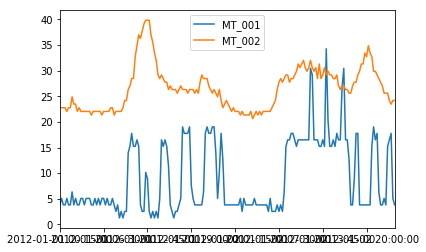

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

In [20]:
average_curves_norm.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,...,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,...,0.318475,0.422753,0.342066,0.288892,0.369187,1.292298,1.149629,1.167326,0.931284,1.006770


#### Plot the first 2 and last 2 clients

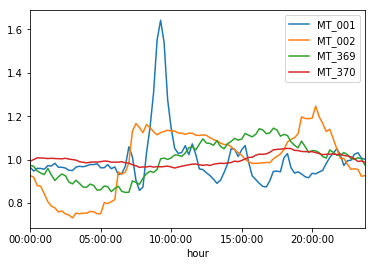

In [21]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [22]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [23]:
X.shape

(349, 96)

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

### Part a

In [24]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [25]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

In [26]:
# Initialize measures
inertias_1 = []
inertias_2 = []
silhouette_avgs = []

# Set-up maximum value for number of clusters
max_K = 30

# Compute measures for each k
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

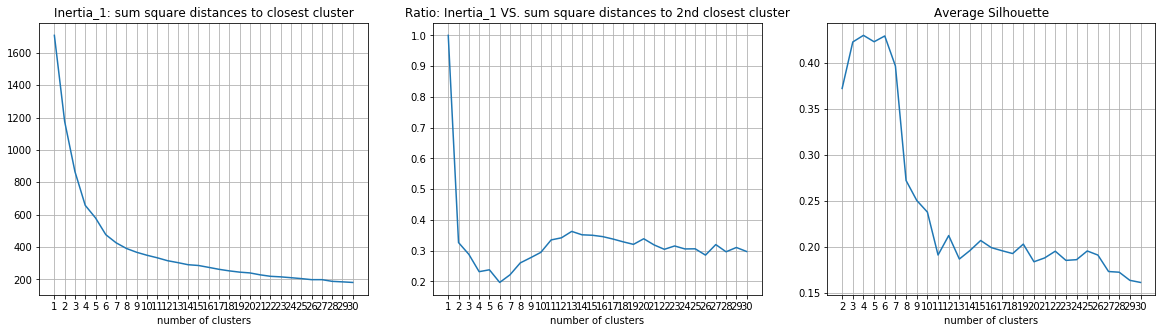

In [27]:
# Plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

By looking at *inertia* alone, we cannot easily identify an appropriate value for k since the value keeps on decreasing rather drastically. However. we can see that the tangential line lies around k = 6, meaning that the rate of decreasing slows down after this point. This is further supported by looking at *inertia2* and *silhouette*, where at k = 6, *inertia2* is the lowest and *silhouette* is the highest.

Therefore, the number of clusters should be 6.

### Part b

In [28]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

In [29]:
y = kmeans.labels_

In [30]:
y.shape

(349,)

In [31]:
centers = kmeans.cluster_centers_

In [32]:
centers.shape

(6, 96)

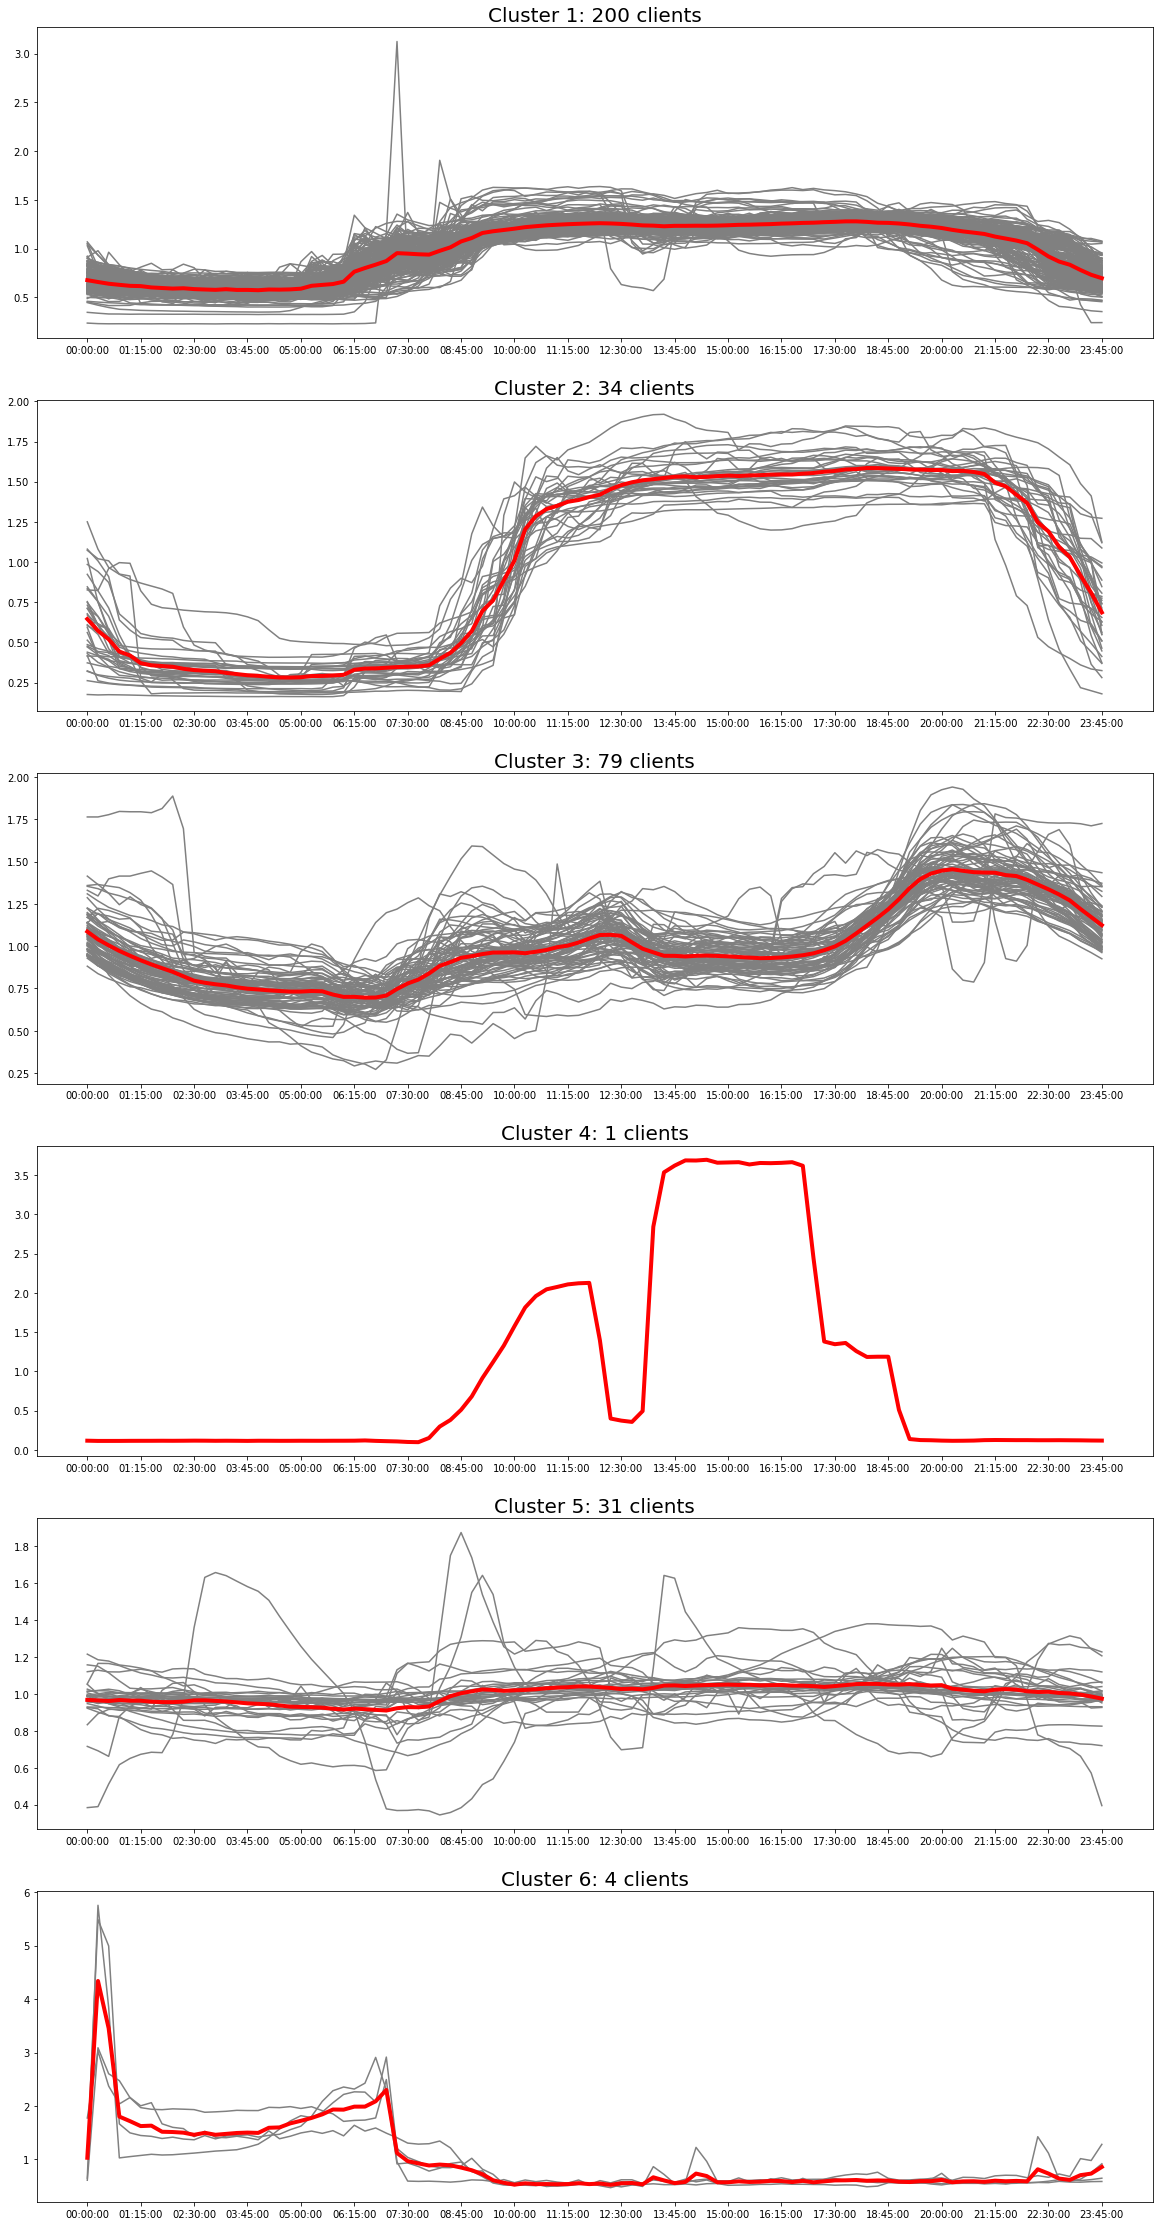

In [33]:
fig = plt.figure(figsize=(20,40))

for c in range(0, 6):
    fig.add_subplot(6,1,c+1)
    c_x = []
    for i,j in enumerate(y):
        # Belong to cluster
        if j == c:
            # Add to list
            c_x.append(i)
    plt.plot(average_curves_norm.iloc[:,c_x],c='grey')
    plt.plot(centers[c],c='red',linewidth=4.0)
    plt.xticks(average_curves_norm.index.values[::5])
    plt.title("Cluster {0}: {1} clients".format(c + 1, len(c_x)),size=20.0)

plt.show()  

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [34]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

In [35]:
len(X)

730

In [36]:
len(X[0])

96

### Part a

In [37]:
# Initialize measures
inertias_1 = []
inertias_2 = []
silhouette_avgs = []

# Set-up maximum value for number of clusters
max_K = 30

# Compute measures for each k
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

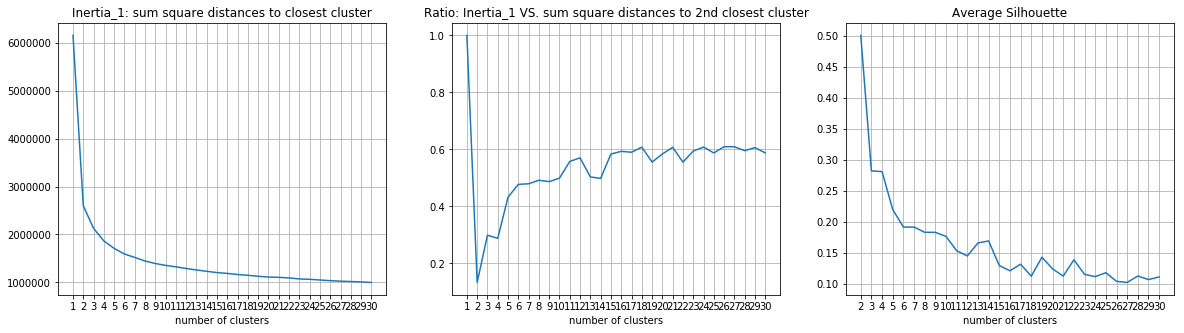

In [38]:
# Plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

The optimal value for K is 2

### Part b

In [39]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [40]:
y = kmeans.labels_

In [41]:
y.shape

(730,)

In [42]:
centers = kmeans.cluster_centers_

In [43]:
centers.shape

(2, 96)

In [44]:
# Create a DataFrame for better readability of X
df_X = pd.DataFrame(X).T
df_X['hour'] = average_curves_norm.index.values
df_X = df_X.set_index('hour')

In [45]:
df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,720,721,722,723,724,725,726,727,728,729
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,31.133250,22.415940,21.793275,23.661270,19.925280,27.397260,21.793275,23.038605,21.170610,21.793275,...,29.887920,26.774595,25.529265,25.529265,23.661270,21.170610,31.133250,28.642590,29.265255,24.906600
00:15:00,28.642590,22.415940,21.170610,22.415940,19.302615,25.529265,21.793275,24.283935,22.415940,19.302615,...,28.019925,28.019925,24.906600,25.529265,23.038605,21.793275,29.265255,29.887920,29.887920,26.774595
00:30:00,27.397260,20.547945,20.547945,22.415940,19.925280,24.283935,21.793275,21.170610,21.170610,19.302615,...,25.529265,25.529265,23.038605,26.151930,23.038605,21.170610,28.019925,27.397260,30.510585,23.661270
00:45:00,24.906600,20.547945,19.925280,21.793275,19.302615,23.661270,21.170610,21.170610,19.302615,18.057285,...,24.283935,24.906600,24.283935,28.019925,23.038605,20.547945,28.019925,28.642590,28.642590,22.415940
01:00:00,24.283935,22.415940,19.302615,22.415940,18.057285,23.038605,20.547945,19.302615,17.434620,16.811955,...,24.283935,24.283935,23.038605,25.529265,23.038605,21.793275,26.151930,26.774595,28.019925,22.415940


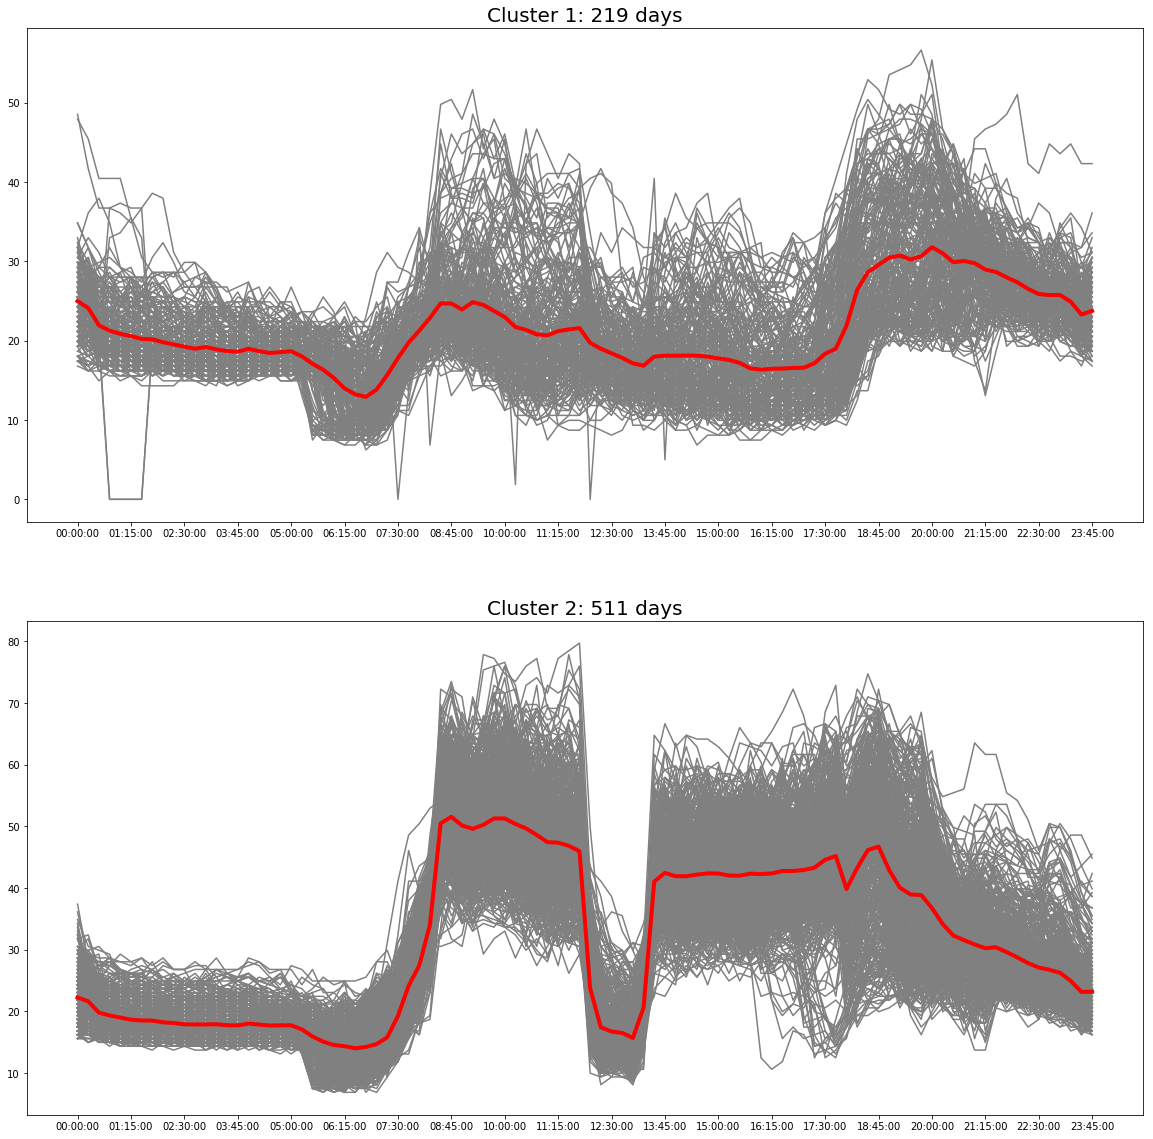

In [46]:
fig = plt.figure(figsize=(20,20))

for c in range(0, 2):
    fig.add_subplot(2,1,c+1)
    c_x = []
    for i,j in enumerate(y):
        # Belong to cluster
        if j == c:
            # Add to list
            c_x.append(i)
    plt.plot(df_X.iloc[:,c_x],c='grey')
    plt.plot(centers[c],c='red',linewidth=4.0)
    plt.xticks(df_X.index.values[::5])
    plt.title("Cluster {0}: {1} days".format(c + 1, len(c_x)),size=20.0)

plt.show()  

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [47]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [48]:
len(daysyear)

730

In [49]:
daysyear[:8]

['tue-2013-01-01',
 'wed-2013-01-02',
 'thu-2013-01-03',
 'fri-2013-01-04',
 'sat-2013-01-05',
 'sun-2013-01-06',
 'mon-2013-01-07',
 'tue-2013-01-08']

Let's take a look at which "days" (e.g. Monday) each of these clusters consist of

In [50]:
from itertools import compress

In [51]:
days = [d[:3] for d in daysyear]

In [52]:
days[:8]

['tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'mon', 'tue']

In [53]:
# Cluster 1
df_c_1 = pd.DataFrame(list(compress(days, y == 0)), columns=['day'])

In [54]:
df_c_1.head()

,day
0,tue
1,sat
2,sun
3,sat
4,sun


In [55]:
df_c_1['day'].value_counts()

sun    104
sat     58
tue     12
mon     12
wed     12
fri     11
thu     10
Name: day, dtype: int64

In [56]:
# Cluster 2
df_c_2 = pd.DataFrame(list(compress(days, y == 1)), columns=['day'])

In [57]:
df_c_2.head()

,day
0,wed
1,thu
2,fri
3,mon
4,tue


In [58]:
df_c_2['day'].value_counts()

thu    94
tue    93
wed    93
fri    93
mon    92
sat    46
Name: day, dtype: int64

Maybe Cluster 1 are weekends and Cluster 2 are weekdays.
Let's grab the statutory holidays in Portugal in 2013 and 2014.

In [59]:
# https://www.officeholidays.com/countries/portugal/2013.php, https://www.officeholidays.com/countries/portugal/2014.php
holidays = ['tue-2013-01-01','fri-2013-03-29','thu-2013-04-25','wed-2013-05-01','mon-2013-06-10','thu-2013-08-15','sun-2013-12-08','wed-2013-12-25',
           'wed-2014-01-01','fri-2014-04-18','fri-2014-04-25','thu-2014-05-01','tue-2014-06-10','fri-2014-08-15','mon-2014-12-08','thu-2014-12-25']

In [60]:
# Re-do daysyear, add 'holiday' in

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
    if daysyear[-1] in holidays:
        daysyear[-1] = 'hol' + daysyear[-1][3:]

In [61]:
days = [d[:3] for d in daysyear]

In [62]:
days[:8]

['hol', 'wed', 'thu', 'fri', 'sat', 'sun', 'mon', 'tue']

In [63]:
# Cluster 1
df_c_1 = pd.DataFrame(list(compress(days, y == 0)), columns=['day'])

In [64]:
df_c_1['day'].value_counts()

sun    103
sat     58
hol     15
tue     10
mon     10
wed      9
fri      8
thu      6
Name: day, dtype: int64

In [65]:
# Cluster 2
df_c_2 = pd.DataFrame(list(compress(days, y == 1)), columns=['day'])

In [66]:
df_c_2['day'].value_counts()

thu    94
tue    93
wed    93
mon    92
fri    92
sat    46
hol     1
Name: day, dtype: int64

Let's take a closer look at the "odd" days in Cluster 1, namely those that are not weekends nor holidays

tue-2013-02-12
mon-2013-04-01
thu-2013-05-02
fri-2013-05-03
mon-2013-08-12
tue-2013-08-13
wed-2013-08-14
fri-2013-08-16
mon-2013-08-19
tue-2013-08-20
wed-2013-08-21
thu-2013-08-22
fri-2013-08-23
mon-2013-08-26
tue-2013-08-27
wed-2013-08-28
thu-2013-08-29
fri-2013-08-30
wed-2013-09-18
mon-2013-12-23
tue-2013-12-24
fri-2013-12-27
tue-2013-12-31
tue-2014-03-04
mon-2014-04-21
fri-2014-05-02
mon-2014-06-09
mon-2014-08-11
tue-2014-08-12
wed-2014-08-13
thu-2014-08-14
mon-2014-08-18
tue-2014-08-19
wed-2014-08-20
thu-2014-08-21
fri-2014-08-22
mon-2014-08-25
tue-2014-08-26
wed-2014-08-27
thu-2014-08-28
fri-2014-08-29
wed-2014-12-24
wed-2014-12-31


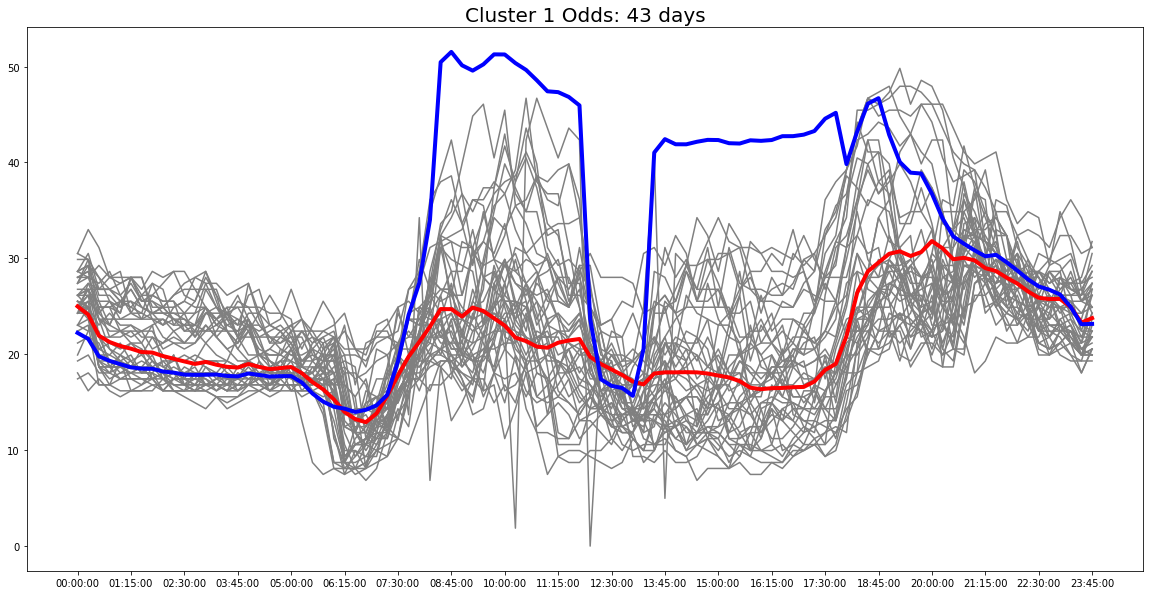

In [67]:
odds = []

for i,j in enumerate(y):
    if j == 0 and days[i] not in ['sun','sat','hol']:
        print(daysyear[i])
        odds.append(i)

# Also plot Cluster 1 centroid (red) and Cluster 2 centroid (blue)
plt.figure(figsize=(20,10))
plt.plot(df_X.iloc[:,odds],c='grey')
plt.plot(centers[0],c='red',linewidth=4.0)
plt.plot(centers[1],c='blue',linewidth=4.0)
plt.xticks(df_X.index.values[::5])
plt.title("Cluster 1 Odds: {0} days".format(len(odds)),size=20.0)
plt.show()

A few of the odd days above are
    - Around holidays, such as 2013-05-02 and 2013-05-02, two days after Labour Day
    - The whole August starting on the 11th, in both 2013 and 2014

It could also be that some of the points are just bad fits and should really be classified as Cluster 2.
    
Overall, we can conclude that the clusters represent weekends/holidays (Cluster 1) and weekdays (Cluster 2). It's highly likely that the client is a business, considering the overall higher consumption in weekdays especially duing work hours, dips around the lunch break time. It's also likely that the client doesn't operate (or operates less) in the month of August.